# Site

For a given position, reference wind speed (WS<sub>ref</sub>) and wind direction (WD<sub>ref</sub>), `Site` provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI) and the probability of each combination of wind direction and wind speed. Furthermore, `Site` is responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).

## Predefined example sites
PyWake contains a few predefined sites of different complexities:
- IEA37Site: `UniformSite` (fix wind speed (9.8m/s), predefined wind sector probability)
- Hornsrev1: `UniformWeibullSite` (weibull distributed wind speed, predefined wind sector propability, uniform wind a over flat wind area)
- ParqueFicticioSite: `WaspGridSite` (Position-dependent weibull distributed wind speed and sector probability. Terrain following distances over non-flat terrain). Loaded from a set of *.grd files exported from WAsP

In [4]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [5]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite
import numpy as np
import matplotlib.pyplot as plt

sites = {"IEA37": IEA37Site(n_wt=16), 
         "Hornsrev1": Hornsrev1Site(), 
         "ParqueFicticio": ParqueFicticioSite()}

## Define your own site
You can define your own site using one of the `Site` classes:

- [UniformWeibullSite](#UniformWeibullSite): Site with uniform sector-dependent weibull distributed wind speed
- [WaspGridSite](#WaspGridSite): Site with gridded non-uniform inflow based on *.grd files exported from WAsP
- [XRSite](#XRSite): The flexible general base class behind all Sites


### UniformWeibullSite

In [6]:
from py_wake.site import UniformWeibullSite
site = UniformWeibullSite(p_wd = [.20,.25,.35,.25], # sector frequencies
                          a = [9.176929,  9.782334,  9.531809,  9.909545], # Weibull scale parameter
                          k = [2.392578, 2.447266, 2.412109, 2.591797], # Weibull shape parameter
                          ti = 0.1 # turbulence intensity, optional (not needed in all cases)
                         )

### WaspGridSite

In [7]:
from py_wake.site import WaspGridSite
from py_wake.examples.data.ParqueFicticio import ParqueFicticio_path
site = WaspGridSite.from_wasp_grd(ParqueFicticio_path)

### XRSite

`XRSite(ds, initial_position=None, interp_method='linear', shear=None, distance=StraightDistance(), default_ws=np.arange(3, 26), bounds='check')`

The `XRSite` is the most general and flexible `Site`. 


**Input arguments**

- `ds`, xarray.Dataset
    - dataset with some required and optional data variables
    - Required data variables:
        - `P`: probability of flow case(s)
    
    or

        - `Weibull_A`: Weibull scale parameter(s)
        - `Weibull_k`: Weibull shape parameter(s)
        - `Sector_frequency`: Probability of each wind direction sector

    - Optional data variables:

        - `WS`: Wind speed, if not present, the reference wind speed `ws` is used
        - `Speedup`: Factor multiplied to the wind speed
        - `Turning`: Wind direction turning
        - `TI`: Turbulence intensity
        - xxx: Custom variables needed by the wind turbines to compute power, ct or loads

    - Each data variable may be constant or depend on a combination of the following inputs (Note, the input variables must be ordered according to the list, i.e. `P(wd,ws)` is ok, while `P(ws,wd)` is not):

        - `i`: Wind turbine position (one position per wind turbine)
        - `x`,`y`: Gridded 2d position
        - `x`,`y`,`h`: Gridded 3d position
        - `time`: Time
        - `wd`: Refernce wind direction
        - `ws` : Reference wind speed
    
    
- `initial_position`, array_like, shape=(#wt, 2), optional
    - wt positions (x,y)

- `interp_method`, {'linear', 'nearest'}, optional
    - interpolation method
- `shear`, function or Shear object, optional
    - Map wind speed, WS from direction, wd to wind speed at height, h: f(WS, wd, h) -> WS_z
    - See py_wake.site.shear
- `distance`, Distance object, optional
    - Calculate distance between wt or points. Default is straight line distance
- `default_ws`, number or array_like, optional
    - Default wind speeds
- `bounds`, {'check', 'limit', 'ignore'}, optional
    - Specifies how to handle out of bounds interpolation:

        - `check`: bounds check is performed. An error is raised if interpolation point outside area
        - `limit`: interpolation points are forced inside the area
        - `ignore`: Faster option with no check. Use this option if data is guaranteed to be inside the area



#### Examples


In [8]:
from py_wake.site import XRSite
from py_wake.site.shear import PowerShear
import xarray as xr
import numpy as np
from py_wake.utils import weibull
from numpy import newaxis as na

f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

# Site with constant wind speed, sector frequency, constant turbulence intensity and power shear
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 10, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=100, alpha=.2))

# Site with wind direction dependent weibull distributed wind speed
uniform_weibull_site = XRSite(
    ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
                  coords={'wd': wd}))


# Site with a speedup and a turning value per WT
x_i, y_i = np.arange(5) * 100, np.zeros(5)  # WT positions
complex_fixed_pos_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': ('i', np.arange(.8, 1.3, .1)),
                   'Turning': ('i', np.arange(-2, 3)),
                   'P': ('wd', f)},
        coords={'i': np.arange(5), 'wd': wd}),
    initial_position=np.array([x_i, y_i]).T)

# Site with gridded speedup information
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.4, .1).reshape((3, 2))),
                   'P': ('wd', f)},
        coords={'x': [0, 500, 1000], 'y': [0, 500], 'wd': wd}))

# Site with ws dependent speedup and wd- and ws distributed probability
P_ws = weibull.cdf(np.array([3, 5, 7, 9, 11, 13]), 10, 2) - weibull.cdf(np.array([0, 3, 5, 7, 9, 11]), 10, 2)
P_wd_ws = P_ws[na, :] * np.array(f)[:, na]
complex_ws_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['ws'], np.arange(.8, 1.4, .1)),
                   'P': (('wd', 'ws'), P_wd_ws), 'TI': ti},
        coords={'ws': [1.5, 4, 6, 8, 10, 12], 'wd': wd}))

### Pregenerated site with wake effects from neighbouring wind farms

In some cases, calculation of wake interaction between the wind farm to optimize and neighbouring wind farms considerably slow down an optimization work flow. To avoid this, a site, which includes wake effects from neighbouring wind farms, can be pregenerated and used for the optimization.

The speed up of this solution depends on the number of turbines in the current and the neighbouring wind farms as well as the type of sites. If the original site is a uniform site, then a pregenerated site with wake effects from neighbouring wind farms may slow down the workflow as it adds interpolation of inflow characteristics in space.

Note also, that a pregenerated site with wake effects from neighbouring wind farms is only eqivalent to the full simulation  if the applied deficit model uses the effective wind speed (some models have an option to switch between effective and free-stream local wind speed). 

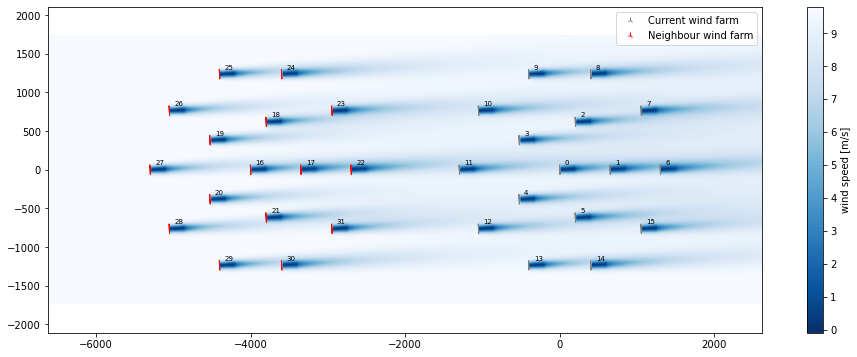

In [9]:
# import and setup site and windTurbines
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.superposition_models import LinearSum

site = IEA37Site(16)

# setup current, neighbour and all positions
wt_x, wt_y = site.initial_position.T
neighbour_x, neighbour_y = wt_x-4000, wt_y
all_x, all_y = np.r_[wt_x,neighbour_x], np.r_[wt_y,neighbour_y]


windTurbines = WindTurbines.from_WindTurbine_lst([IEA37_WindTurbines(),IEA37_WindTurbines()])
windTurbines._names = ["Current wind farm","Neighbour wind farm"]
types = [0]*len(wt_x) + [1]*len(neighbour_x)

wf_model = PropagateDownwind(site, windTurbines,
                                 wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                                 superpositionModel=LinearSum())
# Consider wd=270 +/- 30 deg only
wd_lst = np.arange(240,301)

plt.figure(figsize=(16, 6))
wf_model(all_x, all_y, type=types, wd=267, ws=9.8, h=110).flow_map().plot_wake_map()

Run simulation of all wind turbines and calculate AEP of current wind farm

In [10]:
%%timeit -n 1 -r 1
print(wf_model(all_x, all_y, type=types, ws=9.8, wd=wd_lst).aep().isel(wt=np.arange(len(wt_x))).sum())

<xarray.DataArray 'AEP [GWh]' ()>
array(84.87408987)
56.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Make a flox_box covering the area of interest (i.e. the current wind farm + 100m)

In [11]:
ext = 1000
flow_box = wf_model(neighbour_x, neighbour_y, wd=wd_lst).flow_box(
    x=np.linspace(min(wt_x) - ext, max(wt_x) + ext, 101),
    y=np.linspace(min(wt_y) - ext, max(wt_y) + ext, 101),
    h=110)

Create a new site based on the flow box

In [12]:
from py_wake.site.xrsite import XRSite
wake_site = XRSite.from_flow_box(flow_box)

Plot the "free-stream" inflow wind speed of the current wind farm

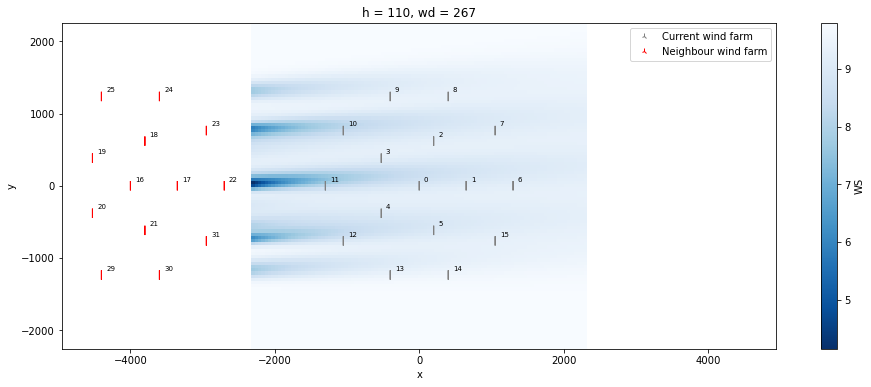

In [13]:
plt.figure(figsize=(16, 6))
wake_site.ds.WS.sel(wd=267).plot(y='y', cmap = 'Blues_r')
windTurbines.plot(all_x, all_y, types, wd=270)

Setup new wind farm model with the new pregenerated site

In [14]:
wf_model_wake_site = PropagateDownwind(wake_site, windTurbines,
                                           wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                                           superpositionModel=LinearSum())

In [15]:
%%timeit -n 1 -r 1
print(wf_model_wake_site(wt_x, wt_y, ws=[9.8], wd=wd_lst).aep().sum())

<xarray.DataArray 'AEP [GWh]' ()>
array(84.8732932)
28.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The AEP is not exactly equal due to interpolation errors. The discrepancy can be lowered by increasing the resolution of the flow box.

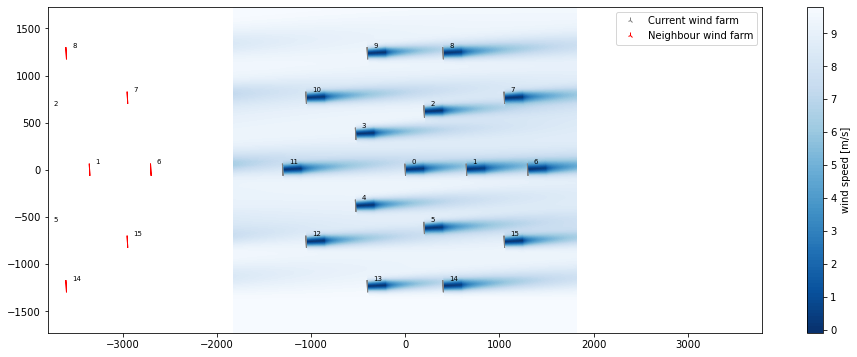

In [16]:
plt.figure(figsize=(16, 6))
wf_model_wake_site(wt_x, wt_y, wd=267, ws=9.8, h=110).flow_map().plot_wake_map()
windTurbines.plot(neighbour_x, neighbour_y, type=1, wd=267)

## Local wind
The method `local_wind` returns a `LocalWind`-dictionary:

In [17]:
localWinds = {name: site.local_wind(x_i=site.initial_position[:,0], # x position
                                    y_i = site.initial_position[:,1], # y position
                                    h_i=site.initial_position[:,0]*0+70, # height
                              ws=None, # defaults to 3,4,..,25
                              wd=None, # defaults to 0,1,...,360
                              ) for name, site in sites.items()}

`LocalWind.coords` contains the current coordinates, e.g.:

- i: Point number. Points can be wind turbine position or just points in a flow map
- wd: Ambient reference wind direction
- ws: Ambient reference wind speed
- x,y,h: position and height of points

while the dictionary itself contains some data variables:

- WD: Local wind direction
- WS: Local wind speed
- TI: Local turbulence intensity
- P: Probability of flow case (wind direction and wind speed)

The `IEA37` site has 16 wind turbines on a uniform site with a fixed wind speed of 9.8 m/s and the data variables therefore only depends on wind direction. 

In [32]:
print (localWinds['IEA37'].coords.keys())
localWinds['IEA37'].P

dict_keys(['wd', 'ws', 'i', 'x', 'y', 'h'])


<xarray.DataArray (wd: 360)>
array([0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
...
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111])
Coordinates:
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

The `Hornsrev1` site has 80 wind turbines on a uniform site and the data variables therefore depends on wind direction and wind speed.

In [33]:
localWinds['Hornsrev1'].P

<xarray.DataArray (wd: 360, ws: 23)>
array([[6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       ...,
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08]])
Coordinates:
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25

Finally, the `ParqueFicticio` site has 8 turbines in a complex terrain and the data variables therefore dependents on both wind direction, wind speed and position

In [34]:
localWinds['ParqueFicticio'].P

<xarray.DataArray (i: 8, wd: 360, ws: 23)>
array([[[3.30521189e-04, 2.90945174e-04, 2.24051965e-04, ...,
         2.17151164e-12, 4.18358259e-13, 7.59823194e-14],
        [3.29678728e-04, 2.89724248e-04, 2.22255957e-04, ...,
         1.42378793e-12, 2.62971871e-13, 4.56948366e-14],
        [3.28803760e-04, 2.88465466e-04, 2.20425575e-04, ...,
         9.24548089e-13, 1.63531488e-13, 2.71554012e-14],
        ...,
        [3.30774594e-04, 2.93358503e-04, 2.28869097e-04, ...,
         6.51548667e-12, 1.39516685e-12, 2.82983824e-13],
        [3.30714479e-04, 2.92588913e-04, 2.27298658e-04, ...,
         4.55200242e-12, 9.41737928e-13, 1.84263977e-13],
        [3.30630133e-04, 2.91784558e-04, 2.25692881e-04, ...,
         3.15619870e-12, 6.30371964e-13, 1.18883000e-13]],

       [[3.26402880e-04, 2.87997698e-04, 2.21675061e-04, ...,
         1.33860940e-12, 2.44544435e-13, 4.19923483e-14],
        [3.25122046e-04, 2.86441420e-04, 2.19674768e-04, ...,
         8.78625057e-13, 1.53854068e-13, 2.52708344e-14],
        [3.23807130e-04, 2.84847122e-04, 2.17641857e-04, ...,
         5.71244313e-13, 9.57776275e-14, 1.50306673e-14],
...
        [2.67779644e-04, 2.42876825e-04, 1.93108505e-04, ...,
         4.16918542e-12, 8.45231139e-13, 1.61577818e-13],
        [2.64604401e-04, 2.39695129e-04, 1.89957454e-04, ...,
         2.80824529e-12, 5.47526848e-13, 1.00466686e-13],
        [2.61389307e-04, 2.36466495e-04, 1.86766787e-04, ...,
         1.87054990e-12, 3.50331881e-13, 6.16267761e-14]],

       [[2.68959764e-04, 2.42025369e-04, 1.89572325e-04, ...,
         1.01396181e-12, 1.78631113e-13, 2.94758748e-14],
        [2.67147742e-04, 2.40179522e-04, 1.87608989e-04, ...,
         7.02329489e-13, 1.19181235e-13, 1.89068219e-14],
        [2.65308930e-04, 2.38304775e-04, 1.85622456e-04, ...,
         4.82828262e-13, 7.88535765e-14, 1.20155220e-14],
        ...,
        [2.81699963e-04, 2.54713471e-04, 2.01754861e-04, ...,
         3.67828002e-12, 7.34988224e-13, 1.38414208e-13],
        [2.77506454e-04, 2.50543880e-04, 1.97741116e-04, ...,
         2.42517629e-12, 4.65286805e-13, 8.39650246e-14],
        [2.73260191e-04, 2.46314760e-04, 1.93680118e-04, ...,
         1.57862026e-12, 2.90422137e-13, 5.01516262e-14]]])
Coordinates:
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
  * i        (i) int32 0 1 2 3 4 5 6 7

Wind speeds at the wind turbines for reference wind speed of 3m/s (k=0):

- `IEA37`: Constant wind speed of 9.8m/s
- `Hornsrev1`: Constant wind speed over the site, 3 m/s
- `ParqueFicticio`: Winds speed depends on both wind direction and position

In [36]:
for name, lw in localWinds.items():
    print (name)
    print (lw.WS) #[:8,0,0])
    print ("="*100)

IEA37
<xarray.DataArray ()>
array(9.8)
Hornsrev1
<xarray.DataArray (ws: 23)>
array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25])
Coordinates:
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
ParqueFicticio
<xarray.DataArray (i: 8, wd: 360, ws: 23)>
array([[[ 3.78471012,  5.04628015,  6.30785019, ..., 29.01611089,
         30.27768093, 31.53925096],
        [ 3.80282588,  5.07043451,  6.33804314, ..., 29.15499845,
         30.42260708, 31.69021571],
        [ 3.82094165,  5.09458887,  6.36823609, ..., 29.29388601,
         30.56753323, 31.84118045],
        ...,
        [ 3.73730114,  4.98306819,  6.22883524, ..., 28.6526421 ,
         29.89840915, 31.1441762 ],
        [ 3.75310413,  5.00413885,  6.25517356, ..., 28.77379836,
         30.02483307, 31.27586779],
        [ 3.76890713,  5.0252095 ,  6.28151188, ..., 28.89495463,
         30.151257  , 31.40755938]],

       [[ 3.95569235,  5.27425647,  6

The ParqueFicticio site models variations within the site, i.e. the local wind speed varies over the area

(262878.0, 264778.0, 6504714.0, 6506614.0)

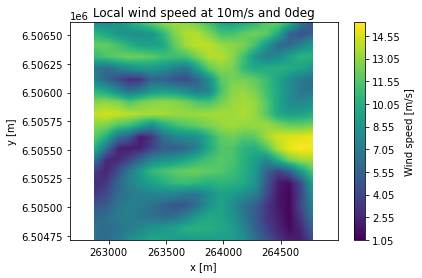

In [37]:
s = sites["ParqueFicticio"]
x = np.linspace(262878,264778,300)
y = np.linspace(6504714,6506614,300)
X,Y = np.meshgrid(x,y)
lw = s.local_wind(X.flatten(),Y.flatten(),30, ws=[10],wd=[0])
Z = lw.WS_ilk.reshape(X.shape)
c = plt.contourf(X,Y,Z, levels=100)
plt.colorbar(c,label='Wind speed [m/s]')
plt.title("Local wind speed at 10m/s and 0deg")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')

## Distance
For the `IEA37Site` and the `Hornsrev1` the distances between points are the straight line distances, as these site types are flat.

For the ParqueFicticioSite, on the other hand, the down-wind distance is larger as it follows the non-flat terrain.

In [38]:
wd = [0, 30,90] # wind direction at source

for name, site in sites.items():
    print ("------- %s -------"%name)
    wt_x, wt_y = site.initial_position[0]
    site.distance.setup(src_x_i=[wt_x, wt_x], src_y_i=[wt_y, wt_y-1000], src_h_i=[70,90]) # wt2 1000m to the south)
    dw_ijl, cw_ijl, dh_ijl = site.distance(WD_il=[wd], src_idx=[0], dst_idx=[1])
    

    print ('Wind direction: \t\t%d deg\t\t%d deg\t\t%d deg'%tuple(wd))
    print ('Down wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(dw_ijl[0,0,:]))
    print ('Cross wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(cw_ijl[0,0,:]))
    print ('Height difference [m]: \t\t%.1f\t\t%.1f\t\t%.1f'%tuple(dh_ijl[0,0,:]))
    print()
    

------- IEA37 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- Hornsrev1 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- ParqueFicticio -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1023.6		886.5		-0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0



## Distribution plots

Site has a few plot function to visualize its properties

In [39]:
import matplotlib.pyplot as plt
site = sites['Hornsrev1']

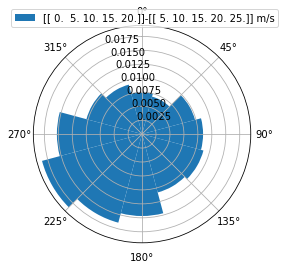

In [40]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

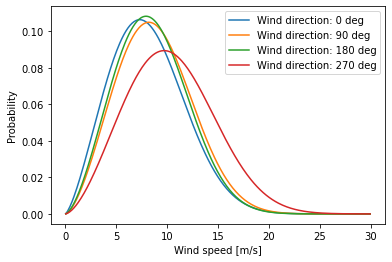

In [41]:
_ = site.plot_ws_distribution(wd=[0,90,180,270])

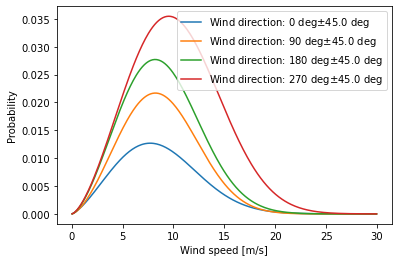

In [42]:
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)